In [ ]:
!pip install accelerate
!pip install diffusers accelerate transformers

In [ ]:
!gdown 1PDujXAkSelYQ8KX_vBGwDr6EkMhJXlA3

In [ ]:
# Import libraries
import pandas as pd
from matplotlib import pyplot as plt
import json
import re
import seaborn as sns
from collections import Counter
import math
import os

from PIL import Image

import nltk
from nltk.tokenize import sent_tokenize
from transformers import BartTokenizer, BartForConditionalGeneration

from transformers import pipeline


# Data Preprocessing and EDA

## Load Dataset

In [ ]:
data_path = '/content/booksummaries.txt'

In [ ]:
data = pd.read_table(data_path, delimiter="\t" , names=['ID','Freebase_ID','BookTitle','Author','Publication Date', 'Genres','Summary',])

Data set has 16559 rows containing meta data including the author of the book the year of publication, gener and the summeries

In [ ]:
# Custom Bar Plotter Function
def bar_plot(df, xlabel,ylabel, title, figsize):
  plt.figure(figsize=figsize)
  ax = sns.barplot(data=df, x=xlabel, y=ylabel)
  ax.set(xlabel=xlabel, ylabel=ylabel)
  plt.title(title)
  plt.show()

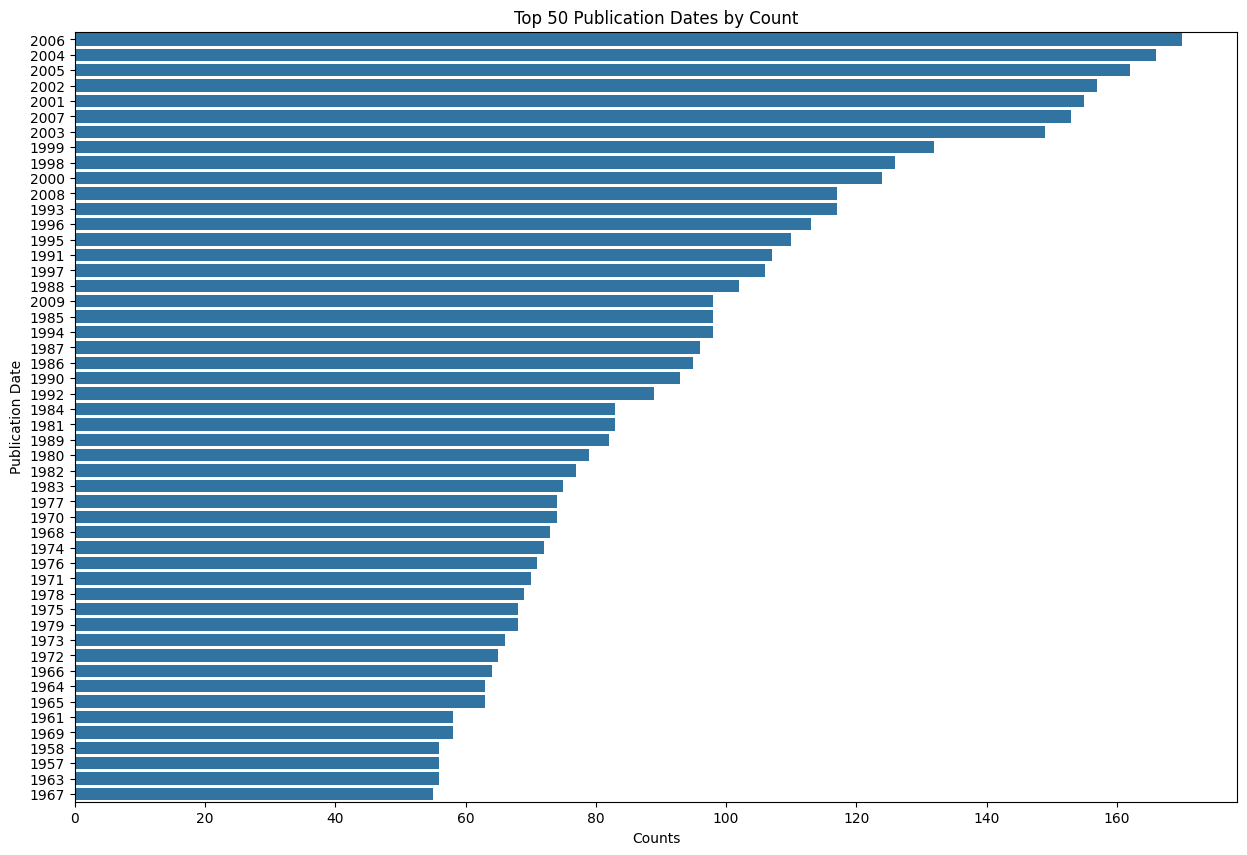

In [ ]:
# Assuming data is your DataFrame
top_Publication_Dates = data['Publication Date'].value_counts().nlargest(50)

# Create DataFrame from top authors
df_top_authors = pd.DataFrame({"Publication Date": top_Publication_Dates.index, "Counts": top_Publication_Dates.values})
bar_plot(df_top_authors,"Counts","Publication Date","Top 50 Publication Dates by Count",(15,10))

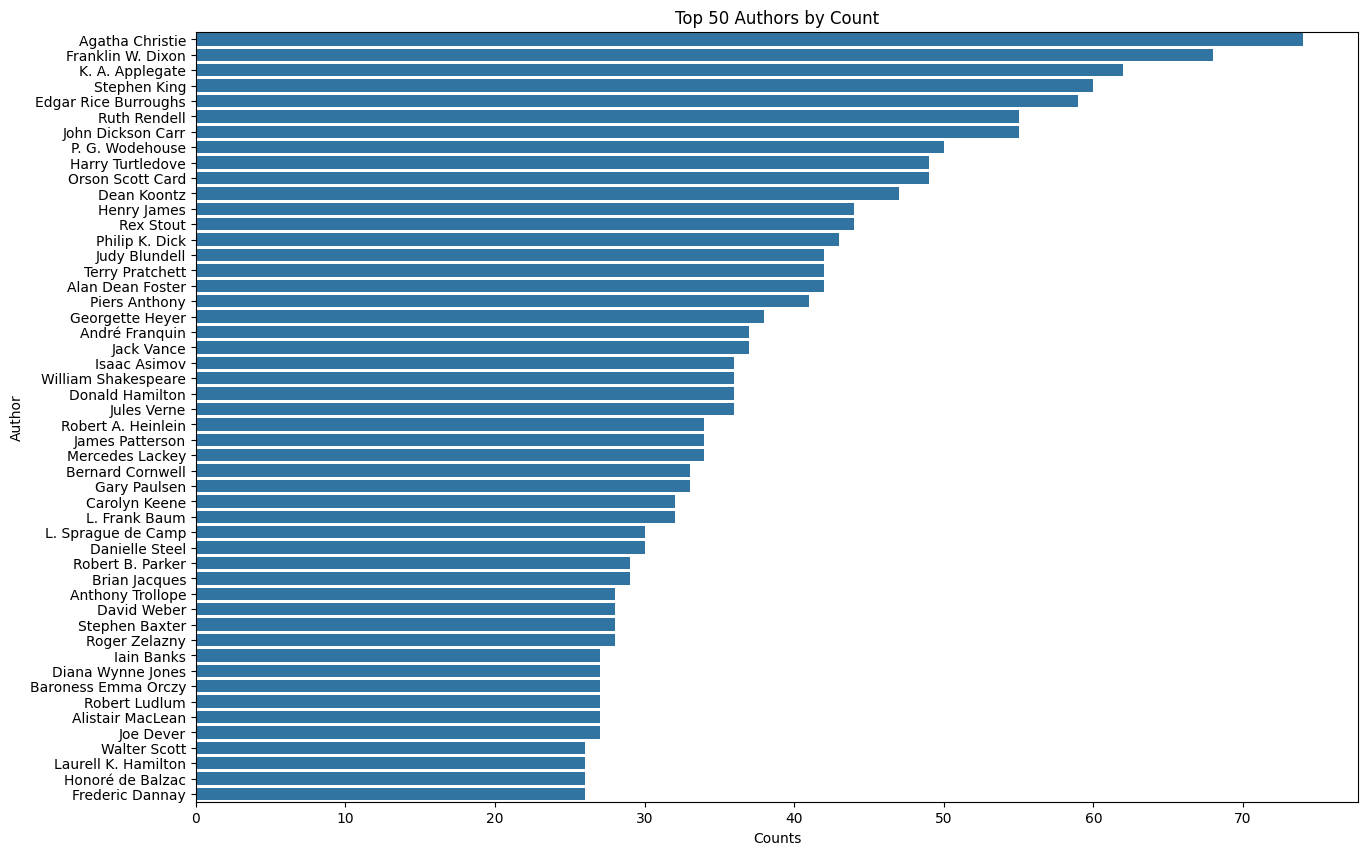

In [ ]:
top_authors = data['Author'].value_counts().nlargest(50)
df_top_authors = pd.DataFrame({"Author": top_authors.index, "Counts": top_authors.values})

bar_plot(df_top_authors, "Counts","Author","Top 50 Authors by Count",(15,10))

### Data Cleaning

- Removing Unnecessary Columns

In [ ]:
# Remove Freebase_ID from dataframe
data.drop(columns = ['ID', 'Freebase_ID'], inplace = True)

- Check for duplicate rows

In [ ]:
has_duplicates = data.duplicated().any()
if has_duplicates:
    print("There are duplicate rows in the DataFrame.")
else:
    print("There are no duplicate rows in the DataFrame.")


There are no duplicate rows in the DataFrame.


-  Identifying and Handling Missing Values

In [ ]:
data.isnull().sum()

BookTitle              0
Author              2382
Publication Date    5610
Genres              3718
Summary                0
dtype: int64

There are 16,559 rows in the DataFrame, and the number of null values in each column is displayed above.

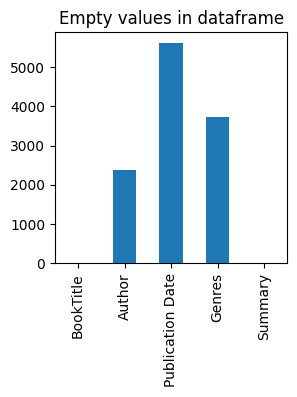

In [ ]:
plt.figure(figsize=(3,3))
data.isna().sum().plot(kind='bar', title='Empty values in dataframe')
plt.show()

In [ ]:
processed_data = data.dropna(subset=['Author', 'Genres'])

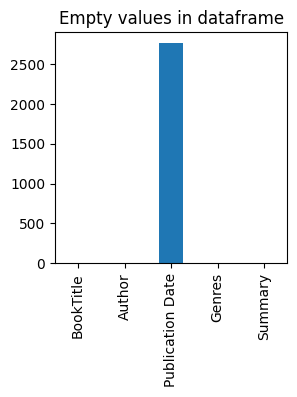

In [ ]:
plt.figure(figsize=(3,3))
processed_data.isna().sum().plot(kind='bar', title='Empty values in dataframe')
plt.show()

Drop rows with missing values in the "Author" and "Genres" fields.

In [ ]:
processed_data.columns

Index(['BookTitle', 'Author', 'Publication Date', 'Genres', 'Summary'], dtype='object')

In [ ]:
processed_data = processed_data.drop(columns = 'Publication Date')

In [ ]:
processed_data.columns

Index(['BookTitle', 'Author', 'Genres', 'Summary'], dtype='object')

In [ ]:
genres_cleaned = []
for i in processed_data['Genres']:
    genres_cleaned.append(list(json.loads(i).values()))
processed_data['Genres'] = genres_cleaned

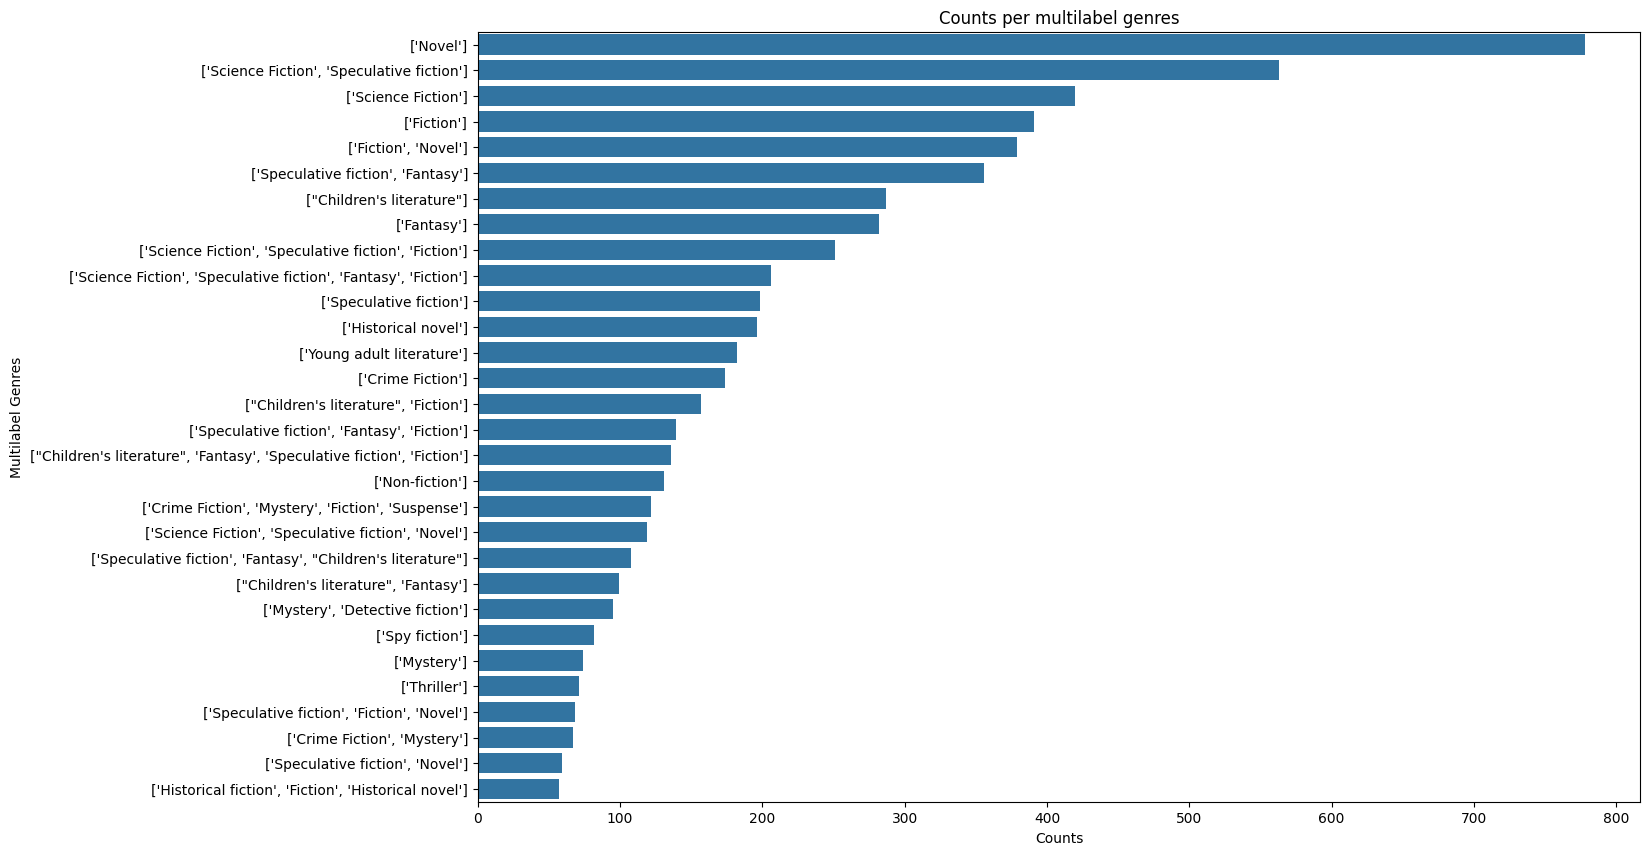

In [ ]:
genres = processed_data['Genres'].map(str).to_numpy()
counts = Counter(genres)
df = pd.DataFrame({"Multilabel Genres": list(counts.keys()),
                   "Counts": list(counts.values())})
g = df.nlargest(columns=["Counts"], n=30)
bar_plot(g, "Counts",'Multilabel Genres','Counts per multilabel genres',(15,10))

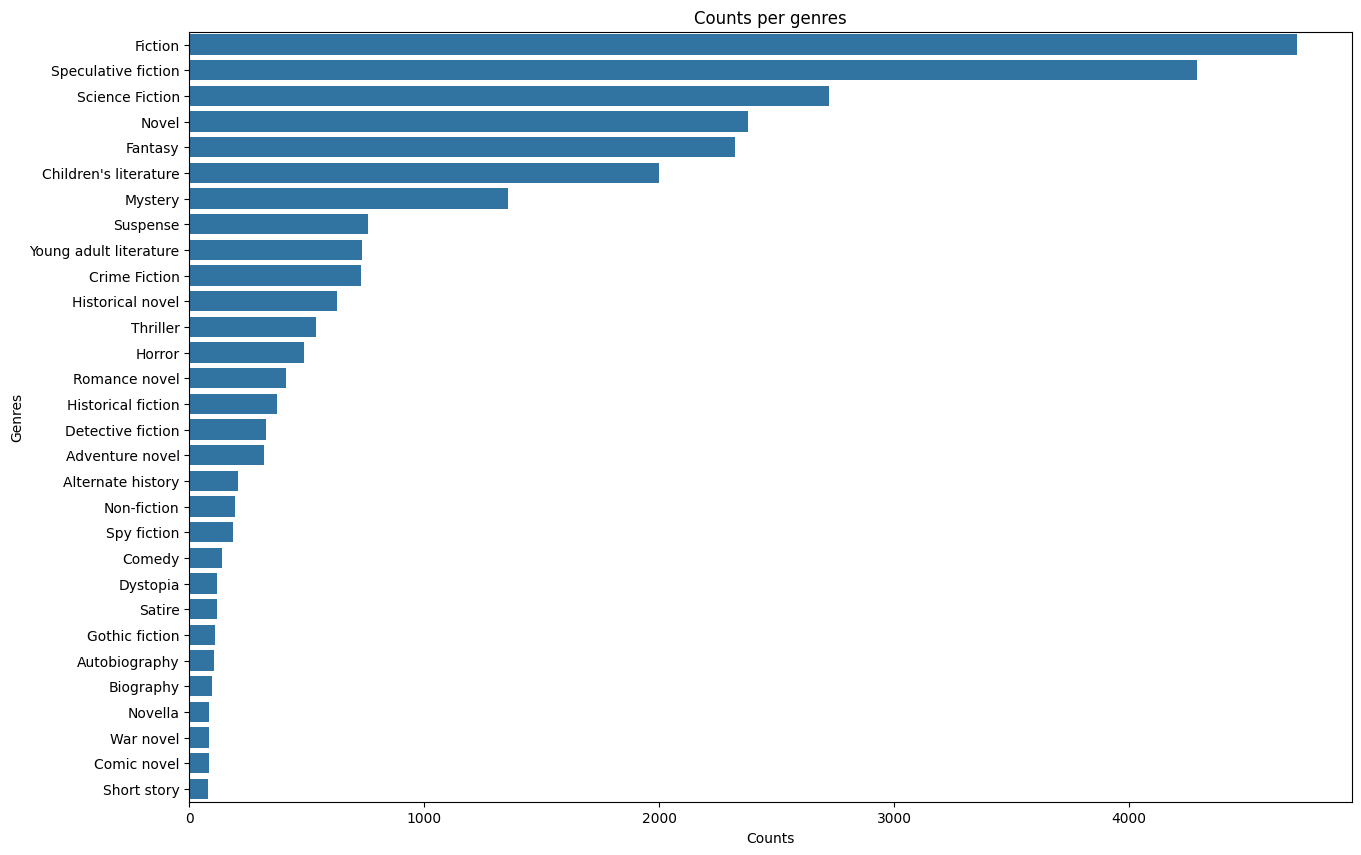

In [ ]:
genres = processed_data['Genres'].explode().tolist()
# genre_counts = pd.Series(genres).value_counts().nlargest(50)
counts = Counter(genres)
df = pd.DataFrame({"Genres": list(counts.keys()),
                   "Counts": list(counts.values())})
g = df.nlargest(columns=["Counts"], n=30)
bar_plot(g, 'Counts',"Genres",'Counts per genres',(15,10))

In [ ]:
print('Before deleting summaries containing no letters, the shape of the data is as follows:',processed_data.shape)
contains_letters = processed_data['Summary'].apply(lambda x: any(c.isalpha() for c in str(x)))
processed_data = processed_data[contains_letters]
print('After deleting summeries containing no letters, the shape of the data is as follows',processed_data.shape)

Before deleting summaries containing no letters, the shape of the data is as follows: (12055, 4)
After deleting summeries containing no letters, the shape of the data is as follows (12050, 4)


As you can see, our dataframe originally contained 5 rows with no letters, so we removed them.

In [ ]:
processed_data.loc[:,"Summary_length"] = processed_data["Summary"].str.len()

In [ ]:
print(processed_data['Summary_length'].describe())

count    12050.000000
mean      2643.680415
std       2977.014016
min         11.000000
25%        749.000000
50%       1686.000000
75%       3548.250000
max      58019.000000
Name: Summary_length, dtype: float64


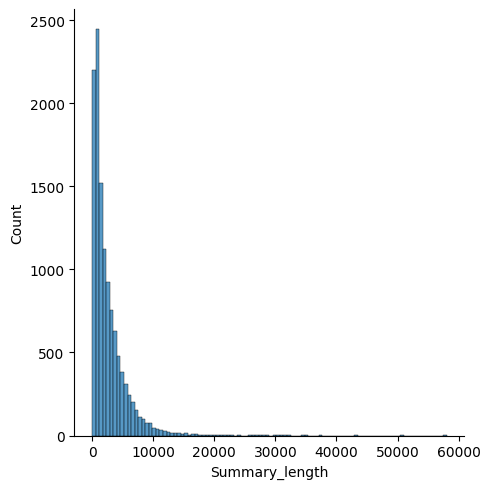

In [ ]:
bin_size = 100
sns.displot(processed_data, x='Summary_length', bins=bin_size, kde=False)

The majority of the data falls within the range of 0 to 10,000.

In [ ]:
print('The minimum length of summaries is:', processed_data['Summary_length'].min())

The minimum length of summaries is: 11


In [ ]:
print('The maximum length of summaries is:', processed_data['Summary_length'].max())

The maximum length of summaries is: 58019


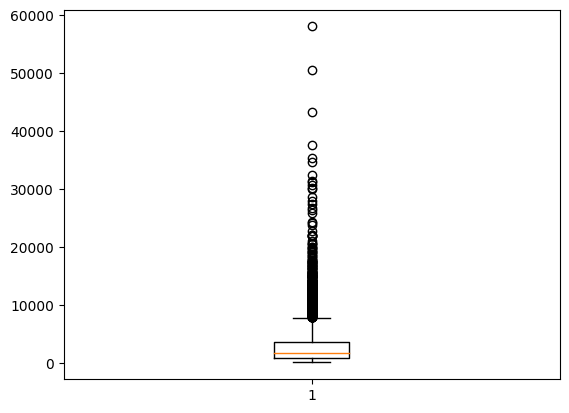

In [ ]:
processed_data.loc[:,'rounded_length'] = processed_data['Summary_length'].apply(lambda x: math.ceil(x / 100) * 100)
plt.boxplot(processed_data['rounded_length'])
plt.show()

We can utilize this box plot to detect and eliminate outliers from our dataset, as it indicates that the majority of summaries have a length of less than 8,000 characters.

In [ ]:
for index, row in processed_data.iterrows():
    text = row['Summary']
    text = text.split(' ')
    processed_data.at[index, 'Summary_word_len'] = int(len(text))


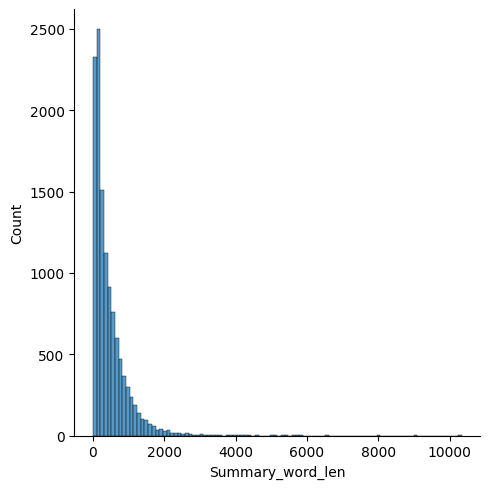

In [ ]:
bin_size = 100
sns.displot(processed_data, x='Summary_word_len', bins=bin_size, kde=False)

In [ ]:
print(processed_data['Summary_word_len'].describe())

count    12050.000000
mean       453.205145
std        514.649174
min          2.000000
25%        127.000000
50%        287.500000
75%        606.000000
max      10335.000000
Name: Summary_word_len, dtype: float64


# NLP Component

## Summerization Pipeline

In [ ]:
# Initialize the BART tokenizer and model
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn")

In [ ]:
def summarize_long_document(document, max_length=40, min_length=10):
    inputs = tokenizer(document, max_length=max_length, return_tensors="pt", truncation=True)
    summary_ids = model.generate(inputs.input_ids, max_length=max_length, min_length=min_length, num_beams=4, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    return summary

In [ ]:
random_sample = processed_data.sample(n=100)

In [ ]:
processed_data['Summary_short'] = None
random_sample['Summary_short'] = random_sample['Summary'].apply(summarize_long_document).astype(str)


In [ ]:
random_sample.loc[:,"Summary_short_length"] = random_sample["Summary_short"].str.len()

In [ ]:
random_sample.to_csv('./subsample.csv')

In [ ]:
random_sample['Summary_short']

9710     Moo contains over a dozen overlapping plot lin...
8339     Anthony "Buck" Rogers is a top pilot who is mo...
12307    Keeley conducts an investigation of the archae...
7469     Natil is a gardener at Kingsley College, a pri...
6181     Clothahump sent Jon-Tom the Spellsinger and Mu...
                               ...                        
1912     The plot follows a nonlinear course through ti...
4147     Charles Dalgleish Forrester is revived from cr...
6239     Kitty Charing is brought up in rural isolation...
674      The book starts off with John Kelly and two ot...
3559     The player takes the role of a starship comman...
Name: Summary_short, Length: 100, dtype: object

## Summerization Sample Output

Input Summary

Book: Zorba the Greek

Genres: Fiction, Novel

Summary:
 The book opens in a cafe in Piraeus, just before dawn on a gusty autumn morning in the 1930s. The narrator, a young Greek intellectual, resolves to set aside his books for a few months after being stung by the parting words of a friend, Stavridakis, who has left for the Caucasus in order to help some ethnic Greeks who are undergoing persecution. He sets off for Crete in order to re-open a disused lignite mine and immerse himself in the world of peasants and working-class people. He is about to dip into his copy of Dante's Divine Comedy when he feels he is being watched; he turns around and sees a man of around sixty peering at him through the glass door. The man enters and immediately approaches him to ask for work. He claims expertise as a chef, a miner, and player of the santuri, or cimbalom, and introduces himself as Alexis Zorba, a Greek born in Romania. The narrator is fascinated by Zorba's lascivious opinions and expressive manner and decides to employ him as a foreman. On their way to Crete, they talk on a great number of subjects, and Zorba's soliloquies set the tone for a large part of the book. On arrival, they reject the hospitality of Anagnostis and Kondomanolious the cafe-owner, and on Zorba's suggestion make their way to Madame Hortense's hotel, which is nothing more than a row of old bathing-huts. They are forced by circumstances to share a bathing-hut. The narrator spends Sunday roaming the island, the landscape of which reminds him of "good prose, carefully ordered, sobere powerful and restrained" and reads Dante. On returning to the hotel for dinner, the pair invite Madame Hortense to their table and get her to talk about her past as a courtesan. Zorba gives her the pet-name "Bouboulina" and, with the help of his cimbalom, seduces her. The protagonist seethes in his room while listening to the sounds of their impassioned lovemaking. The next day, the mine opens and work begins. The narrator, who has socialist ideals, attempts to get to know the workers, but Zorba warns him to keep his distance: "Man is a brute.... If you're cruel to him, he respects and fears you. If you're kind to him, he plucks your eyes out." Zorba himself plunges into the work, which is characteristic of his overall attitude, which is one of being absorbed in whatever one is doing or whomever one is with at that moment. Quite frequently Zorba works long hours and requests not to be interrupted while working. The narrator and Zorba have a great many lengthy conversations, about a variety of things, from life to religion, each other's past and how they came to be where they are now, and the narrator learns a great deal about humanity from Zorba that he otherwise had not gleaned from his life of books and paper. The narrator absorbs a new zest for life from his experiences with Zorba and the other people around him, but reversal and tragedy mark his stay on Crete, and, alienated by their harshness and amorality, he eventually returns to the mainland once his and Zorba's ventures are completely financially spent. Having overcome one of his own demons (such as his internal "no," which the narrator equates with the Buddha, whose teachings he has been studying and about whom he has been writing for much of the narrative, and who he also equates with "the void") and having a sense that he is needed elsewhere (near the end of the novel, the narrator has a premonition of the death of his old friend Stavridakis, which plays a role in the timing of his departure to the mainland), the narrator takes his leave of Zorba for the mainland, which, despite the lack of any major outward burst of emotionality, is significantly emotionally wrenching for both Zorba and the narrator. It almost goes without saying that the two (the narrator and Zorba) will remember each other for the duration of their natural lives.

Output

Condensed Summary:
The book opens in a cafe in Piraeus, just before dawn on a gusty autumn morning in the 1930s. The narrator, a young Greek intellectual, resolves to set aside his books for a few months after being stung by a friend.

# Computer Vision Component

## Text-to-Image Pipeline

In [ ]:
from diffusers import StableDiffusionXLPipeline
import torch
pipe = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/sdxl-turbo",
    torch_dtype=torch.float16,
    variant="fp16"
).to("cuda")

In [ ]:
image_path = "./image_folder/"
if not os.path.exists(image_path):
    os.makedirs(image_path)

def get_img(summary, book_name):
    img = pipe(summary, num_inference_steps=1, guidance_scale=0.0).images[0]
    image_name = f"{book_name}.png"  # Assuming the images are in PNG format
    img.save(image_path+image_name,"PNG")  # Save the image with the book name as the filename
    # return image_path  # Return the path to the saved image

# Assuming random_sample contains the book names in a column named 'BookName'
random_sample['Image_Path'] = random_sample.apply(lambda row: get_img(row['Summary'], row['BookTitle']), axis=1)

## Text-to-Image Sample Output

Book: Zorba the Greek

Genres: Fiction, Novel

Condensed Summary:
The book opens in a cafe in Piraeus, just before dawn on a gusty autumn morning in the 1930s. The narrator, a young Greek intellectual, resolves to set aside his books for a few months after being stung by a friend.

![Zorba the Greek.png](https://i.imghippo.com/files/XVvZq1714419334.png)